<a href="https://colab.research.google.com/github/mmartigani/RoadMapIA/blob/main/Decision_RNA_Profunda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [4]:
df = pd.read_csv("/content/creditcard.csv")

In [6]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [7]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 27819


In [8]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

,count
Class,
0.0,27725
1.0,93


In [9]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27819 entries, 0 to 27818
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    27819 non-null  int64  
 1   V1      27818 non-null  float64
 2   V2      27818 non-null  float64
 3   V3      27818 non-null  float64
 4   V4      27818 non-null  float64
 5   V5      27818 non-null  float64
 6   V6      27818 non-null  float64
 7   V7      27818 non-null  float64
 8   V8      27818 non-null  float64
 9   V9      27818 non-null  float64
 10  V10     27818 non-null  float64
 11  V11     27818 non-null  float64
 12  V12     27818 non-null  float64
 13  V13     27818 non-null  float64
 14  V14     27818 non-null  float64
 15  V15     27818 non-null  float64
 16  V16     27818 non-null  float64
 17  V17     27818 non-null  float64
 18  V18     27818 non-null  float64
 19  V19     27818 non-null  float64
 20  V20     27818 non-null  float64
 21  V21     27818 non-null  float64
 22

In [10]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

,0
Time,False
V1,True
V2,True
V3,True
V4,True
V5,True
V6,True
V7,True
V8,True
V9,True


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,27819.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,...,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000,27818.000000
mean,20434.634315,-0.217255,0.149360,0.723559,0.221251,-0.199312,0.084607,-0.125687,0.028612,0.394412,...,-0.035045,-0.126646,-0.041207,0.010602,0.129963,0.023506,0.013398,0.004055,77.297298,0.003343
std,11866.057310,1.866645,1.545773,1.648474,1.425213,1.431480,1.325535,1.308413,1.314408,1.262314,...,0.803370,0.642121,0.544077,0.590914,0.436275,0.513862,0.393823,0.278450,219.651476,0.057724
min,0.000000,-30.552380,-40.978852,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097,...,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.338556,-8.567638,-9.617915,0.000000,0.000000
25%,9037.500000,-0.951060,-0.424408,0.271315,-0.690871,-0.788013,-0.658281,-0.595865,-0.162449,-0.420660,...,-0.246695,-0.547732,-0.174773,-0.326892,-0.132690,-0.336775,-0.063637,-0.008436,6.442500,0.000000
50%,24675.000000,-0.259642,0.163461,0.855090,0.202149,-0.230110,-0.174349,-0.068385,0.032587,0.305709,...,-0.093654,-0.100015,-0.049634,0.063056,0.169235,-0.054798,0.008119,0.020201,19.950000,0.000000
75%,31319.000000,1.166130,0.803933,1.483404,1.102574,0.316960,0.471794,0.445844,0.290104,1.152587,...,0.079173,0.281732,0.075486,0.398937,0.412015,0.305465,0.091483,0.076658,69.507500,0.000000
max,34712.000000,1.960497,16.713389,4.101716,13.143668,34.099309,22.529298,36.677268,20.007208,10.392889,...,22.614889,5.805795,13.876221,4.014444,5.525093,3.517346,11.135740,4.860769,7879.420000,1.000000


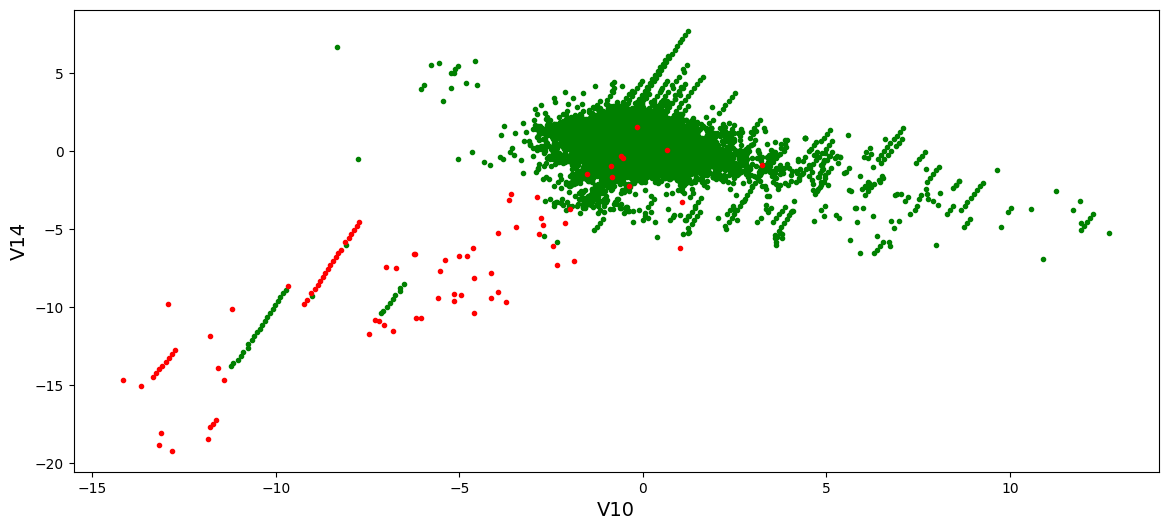

In [12]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [13]:
df = df.drop(["Time", "Amount"], axis=1)

In [14]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [15]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

In [16]:
X_train_reduced = X_train[["V10", "V14"]].copy()
X_val_reduced = X_val[["V10", "V14"]].copy()
X_test_reduced = X_test[["V10", "V14"]].copy()

In [17]:
X_train_reduced

,V10,V14
12033,-1.398574,1.405684
8685,-0.472399,1.365810
25330,0.493408,-0.858712
9039,-0.983010,0.342952
20793,-1.433867,-3.210523
...,...,...
21575,0.166832,1.109040
5390,-0.014454,0.547987
860,-1.031219,0.566649
15795,0.859842,0.754274


In [18]:
# Definición de la arquitectura de la red neuronal
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))#, input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))#, input_shape=(X_train_reduced.shape[1],)))

model.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Precision'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Resumen de las capas del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Entrenamos el modelo
history = model.fit(X_train_reduced,
                   y_train,
                   epochs=30,
                   validation_data=(X_val_reduced, y_val))

Epoch 1/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - Precision: 0.0203 - accuracy: 0.9509 - loss: nan - val_Precision: 0.0000e+00 - val_accuracy: 0.9971 - val_loss: nan
Epoch 2/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.0000e+00 - accuracy: 0.9973 - loss: nan - val_Precision: 0.0000e+00 - val_accuracy: 0.9971 - val_loss: nan
Epoch 3/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Precision: 0.0000e+00 - accuracy: 0.9977 - loss: nan - val_Precision: 0.0000e+00 - val_accuracy: 0.9971 - val_loss: nan
Epoch 4/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Precision: 0.0000e+00 - accuracy: 0.9972 - loss: nan - val_Precision: 0.0000e+00 - val_accuracy: 0.9971 - val_loss: nan
Epoch 5/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.0000e+00 - accuracy: 0.9966 - loss: nan - val_Precision: 0.0000e+00 - val_accuracy: 0.9971 - val_loss: nan
Epoch 6/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.0000e+00 - accuracy: 0.9961 - loss: nan - val_Precision: 0.0000e+00

In [21]:
def plot_ann_decision_boundary(X, y, model, steps=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                         np.linspace(mins[1], maxs[1], 1000))

    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = labels.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

    plt.xlabel("V10", fontsize=14)
    plt.ylabel("V14", fontsize=14)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step


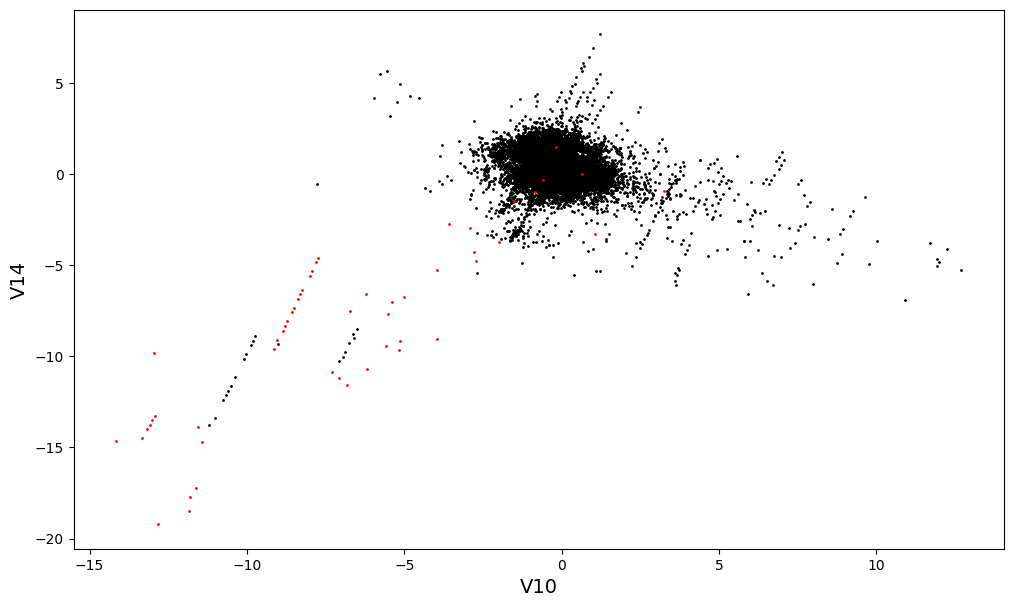

In [22]:
plt.figure(figsize=(12, 7))
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

In [34]:
# Predicción con el conjunto de datos de entrenamiento
y_pred = model.predict(X_train_reduced).round(0)

522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step


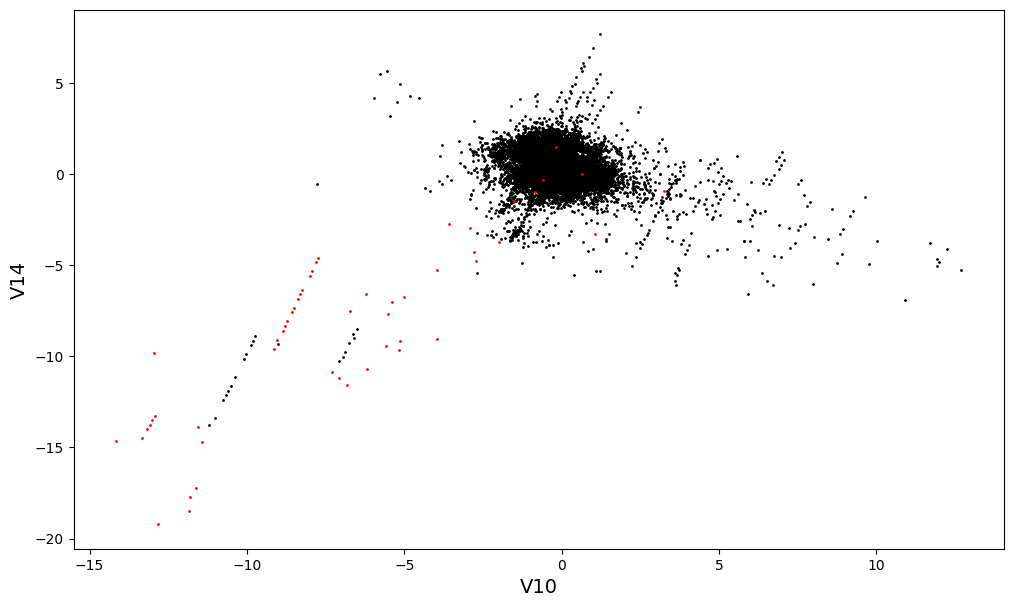

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(X_train_reduced[y_pred==1]["V10"], X_train_reduced[y_pred==1]["V14"], 'go', markersize=4)
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

In [32]:
# Predicción con el conjunto de datos de prueba
y_pred = model.predict(X_test_reduced).round(0)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
